The cell below removes the annoying app bar thing at the bottom of a notebook.

In [1]:
%%javascript
$('.nbp-app-bar').toggle()

<IPython.core.display.Javascript object>

In [112]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import datetime
import calendar
import sqlite3
import seaborn as sns
#import pysal as ps
#from pysal.contrib.viz import mapping as maps
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomTreesEmbedding, RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix, auc, roc_curve, classification_report
from sklearn.multiclass import OneVsRestClassifier
from sklearn.utils import resample


%matplotlib inline

The cell below makes it so pandas will show me all the columns.

In [3]:
pd.set_option('display.max_columns', 40)

The below cell loads the spatialite extention to sqlite. I got the code from the spatialite mailing list
https://groups.google.com/d/msg/spatialite-users/o0jUwMUqx_g/OEat2JTUAAAJ
I can get it to work without geopandas. With geopandas imported it kills the ipython kernel within seconds. Ironic! Without one, the other is useless.

In [ ]:
#conn = sqlite3.connect(':memory:') 
#conn.enable_load_extension(True) 
#conn.execute("SELECT load_extension('mod_spatialite')") 

The below code for importing all the sql data came from: https://www.dataquest.io/blog/python-pandas-databases/

In [4]:
conn = sqlite3.connect("./data/FPA_FOD_20170508.sqlite")

In [ ]:
#this is if you want to read the data in as tuples

#cur = conn.cursor()
#cur.execute("SELECT * FROM fires;")
#results = cur.fetchall()

In [5]:
df_all = pd.read_sql_query("SELECT * FROM fires;", conn)
#this grabs the whole db and puts it into a df using the sqlite3.Connection

In [6]:
df_all.shape

(1880465, 39)

In [7]:
df_all.head(2)

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,LOCAL_INCIDENT_ID,FIRE_CODE,FIRE_NAME,ICS_209_INCIDENT_NUMBER,ICS_209_NAME,MTBS_ID,MTBS_FIRE_NAME,COMPLEX_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,1,PNF-47,BJ8K,FOUNTAIN,None,None,None,None,None,2005,2453403.5,33,1300,9.0,Miscellaneous,2453403.5,33.0,1730,0.10,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,13,13,AAC0,PIGEON,None,None,None,None,None,2004,2453137.5,133,0845,1.0,Lightning,2453137.5,133.0,1530,0.25,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...


Since pandas can't handle the geometry information the Shape column is useless anyway, I'm going to drop it. It lives on in the original sqlite db.

In [8]:
df_all.drop(['Shape'], axis=1, inplace=True)

In [9]:
df_all.columns

Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME'],
      dtype='object')

In [10]:
df_all.STAT_CAUSE_DESCR.unique()

array(['Miscellaneous', 'Lightning', 'Debris Burning', 'Campfire',
       'Equipment Use', 'Arson', 'Children', 'Railroad', 'Smoking',
       'Powerline', 'Structure', 'Fireworks', 'Missing/Undefined'],
      dtype=object)

There are entries in my target column that I can't use so I am dropping them.

In [11]:
df_all.drop(df_all[df_all['STAT_CAUSE_DESCR'] == 'Missing/Undefined'].index, inplace=True)

In [12]:
df_all.shape

(1713742, 38)

In [13]:
df_all.dtypes

OBJECTID                        int64
FOD_ID                          int64
FPA_ID                         object
SOURCE_SYSTEM_TYPE             object
SOURCE_SYSTEM                  object
NWCG_REPORTING_AGENCY          object
NWCG_REPORTING_UNIT_ID         object
NWCG_REPORTING_UNIT_NAME       object
SOURCE_REPORTING_UNIT          object
SOURCE_REPORTING_UNIT_NAME     object
LOCAL_FIRE_REPORT_ID           object
LOCAL_INCIDENT_ID              object
FIRE_CODE                      object
FIRE_NAME                      object
ICS_209_INCIDENT_NUMBER        object
ICS_209_NAME                   object
MTBS_ID                        object
MTBS_FIRE_NAME                 object
COMPLEX_NAME                   object
FIRE_YEAR                       int64
DISCOVERY_DATE                float64
DISCOVERY_DOY                   int64
DISCOVERY_TIME                 object
STAT_CAUSE_CODE               float64
STAT_CAUSE_DESCR               object
CONT_DATE                     float64
CONT_DOY    

In [14]:
df_all.isnull().sum()

OBJECTID                            0
FOD_ID                              0
FPA_ID                              0
SOURCE_SYSTEM_TYPE                  0
SOURCE_SYSTEM                       0
NWCG_REPORTING_AGENCY               0
NWCG_REPORTING_UNIT_ID              0
NWCG_REPORTING_UNIT_NAME            0
SOURCE_REPORTING_UNIT               0
SOURCE_REPORTING_UNIT_NAME          0
LOCAL_FIRE_REPORT_ID          1297372
LOCAL_INCIDENT_ID              705847
FIRE_CODE                     1396084
FIRE_NAME                      839288
ICS_209_INCIDENT_NUMBER       1691038
ICS_209_NAME                  1691038
MTBS_ID                       1703584
MTBS_FIRE_NAME                1703584
COMPLEX_NAME                  1708655
FIRE_YEAR                           0
DISCOVERY_DATE                      0
DISCOVERY_DOY                       0
DISCOVERY_TIME                 770477
STAT_CAUSE_CODE                     0
STAT_CAUSE_DESCR                    0
CONT_DATE                      796359
CONT_DOY    

I'm going to create a new df, df_pred, by dropping columns from the FPA_FOD data. I'm going to read that into a csv so I have it for later, and then stop using the full set. I will keep the full set on my SSD, of course. I am making these decisions based on the data atlas located here: https://www.kaggle.com/davideanastasia/contour-map-of-us-wildfire-dataset/data

In [15]:
df_all['FIRE_CODE'].value_counts()

D44Z    9451
5555    5144
D5GJ    3459
0001    3329
0000    1928
2300    1892
EKV3    1032
4700    1003
EKW0     938
0100     904
EKT5     883
5900     833
EKV0     756
EK2R     729
7000     721
EKV5     703
EK2D     690
EK3D     666
EK2N     660
EKV6     647
EK2A     624
EKT4     614
EK2B     585
EK2Q     551
7500     537
EN0A     533
EK2F     513
EKW2     504
EKS5     495
EKT1     493
        ... 
CWC0       1
EA0A       1
EV9K       1
A5VX       1
HCR3       1
DP1T       1
EH9V       1
H2BP       1
BTE3       1
H6XX       1
CE7F       1
JZK9       1
B12M       1
CSS3       1
C83H       1
DH2A       1
DLT9       1
ELW1       1
JJ3J       1
H40H       1
N877       1
DQ33       1
R966       1
E9LB       1
DSN9       1
C2CW       1
EMB7       1
ETE9       1
E39R       1
DKY3       1
Name: FIRE_CODE, Length: 166669, dtype: int64

I'm going to drop features that I don't care about and then do feature engineering.

In [16]:
df_all = df_all.drop(['OBJECTID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
                  'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
                  'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
                  'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
                  'LOCAL_INCIDENT_ID', 'FIRE_NAME',
                  'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
                  'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_TIME', 
                  'STAT_CAUSE_CODE', 'CONT_TIME', 
                  'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'OWNER_CODE', 
                  'OWNER_DESCR', 'COUNTY', 'FIPS_NAME'], axis=1)

#at some point redo this. Instead of doing a drop just include all feats I want to keep. Much more readable, shorter

In [17]:
df_all.shape

(1713742, 10)

In [18]:
df_all.head(20)

,FOD_ID,FIRE_CODE,DISCOVERY_DATE,DISCOVERY_DOY,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,FIRE_SIZE,STATE,FIPS_CODE
0,1,BJ8K,2453403.5,33,Miscellaneous,2453403.5,33.0,0.10,CA,063
1,2,AAC0,2453137.5,133,Lightning,2453137.5,133.0,0.25,CA,061
2,3,A32W,2453156.5,152,Debris Burning,2453156.5,152.0,0.10,CA,017
3,4,None,2453184.5,180,Lightning,2453189.5,185.0,0.10,CA,003
4,5,None,2453184.5,180,Lightning,2453189.5,185.0,0.10,CA,003
5,6,None,2453186.5,182,Lightning,2453187.5,183.0,0.10,CA,005
6,7,None,2453187.5,183,Lightning,2453188.5,184.0,0.10,CA,017
7,8,BK5X,2453437.5,67,Debris Burning,2453437.5,67.0,0.80,CA,None
8,9,BLPQ,2453444.5,74,Debris Burning,2453444.5,74.0,1.00,CA,None
9,10,None,2453187.5,183,Lightning,2453188.5,184.0,0.10,CA,005


Time for feature engineering.

The 2 columns with the dates for discovery and containment are in the Julian format so I will have to convert them into gregorian timestamps and then engineer a duration. I do think day of year discovered will have some predictive power and will keep that column. I will also engineer month and a day-of-week discovered features.

In [19]:
df_all['START_DATE'] = pd.to_datetime(df_all['DISCOVERY_DATE'], unit='D', infer_datetime_format=True, origin='julian')

In [20]:
df_all['END_DATE'] = pd.to_datetime(df_all['CONT_DATE'], unit='D', infer_datetime_format=True, origin='julian')

In [21]:
df_all.head(2)

,FOD_ID,FIRE_CODE,DISCOVERY_DATE,DISCOVERY_DOY,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,FIRE_SIZE,STATE,FIPS_CODE,START_DATE,END_DATE
0,1,BJ8K,2453403.5,33,Miscellaneous,2453403.5,33.0,0.10,CA,063,2005-02-02,2005-02-02
1,2,AAC0,2453137.5,133,Lightning,2453137.5,133.0,0.25,CA,061,2004-05-12,2004-05-12


In [22]:
df_all = df_all.drop(['DISCOVERY_DATE', 'CONT_DATE'], axis=1)

In [23]:
df_all.head(3)

,FOD_ID,FIRE_CODE,DISCOVERY_DOY,STAT_CAUSE_DESCR,CONT_DOY,FIRE_SIZE,STATE,FIPS_CODE,START_DATE,END_DATE
0,1,BJ8K,33,Miscellaneous,33.0,0.10,CA,063,2005-02-02,2005-02-02
1,2,AAC0,133,Lightning,133.0,0.25,CA,061,2004-05-12,2004-05-12
2,3,A32W,152,Debris Burning,152.0,0.10,CA,017,2004-05-31,2004-05-31


In [24]:
df_all['BURN_TIME'] = (df_all['END_DATE'] - df_all['START_DATE']).astype('timedelta64[D]')

In [25]:
df_all['MONTH'] = pd.DatetimeIndex(df_all['START_DATE']).month

In [26]:
df_all['DOW'] = pd.DatetimeIndex(df_all['START_DATE']).weekday_name

In [27]:
df_all.head(3)

,FOD_ID,FIRE_CODE,DISCOVERY_DOY,STAT_CAUSE_DESCR,CONT_DOY,FIRE_SIZE,STATE,FIPS_CODE,START_DATE,END_DATE,BURN_TIME,MONTH,DOW
0,1,BJ8K,33,Miscellaneous,33.0,0.10,CA,063,2005-02-02,2005-02-02,0.0,2,Wednesday
1,2,AAC0,133,Lightning,133.0,0.25,CA,061,2004-05-12,2004-05-12,0.0,5,Wednesday
2,3,A32W,152,Debris Burning,152.0,0.10,CA,017,2004-05-31,2004-05-31,0.0,5,Monday


In [28]:
df_all = df_all.drop(['CONT_DOY'], axis=1)

In [29]:
df_all = df_all.drop(['END_DATE'], axis=1)

In [30]:
df_all.head(3)

,FOD_ID,FIRE_CODE,DISCOVERY_DOY,STAT_CAUSE_DESCR,FIRE_SIZE,STATE,FIPS_CODE,START_DATE,BURN_TIME,MONTH,DOW
0,1,BJ8K,33,Miscellaneous,0.10,CA,063,2005-02-02,0.0,2,Wednesday
1,2,AAC0,133,Lightning,0.25,CA,061,2004-05-12,0.0,5,Wednesday
2,3,A32W,152,Debris Burning,0.10,CA,017,2004-05-31,0.0,5,Monday


In [31]:
df_all = df_all.drop(['FOD_ID'], axis=1)

In [32]:
df_all.head()

,FIRE_CODE,DISCOVERY_DOY,STAT_CAUSE_DESCR,FIRE_SIZE,STATE,FIPS_CODE,START_DATE,BURN_TIME,MONTH,DOW
0,BJ8K,33,Miscellaneous,0.10,CA,063,2005-02-02,0.0,2,Wednesday
1,AAC0,133,Lightning,0.25,CA,061,2004-05-12,0.0,5,Wednesday
2,A32W,152,Debris Burning,0.10,CA,017,2004-05-31,0.0,5,Monday
3,None,180,Lightning,0.10,CA,003,2004-06-28,5.0,6,Monday
4,None,180,Lightning,0.10,CA,003,2004-06-28,5.0,6,Monday


In [33]:
df_all['BURN_TIME'].isnull().sum()

796359

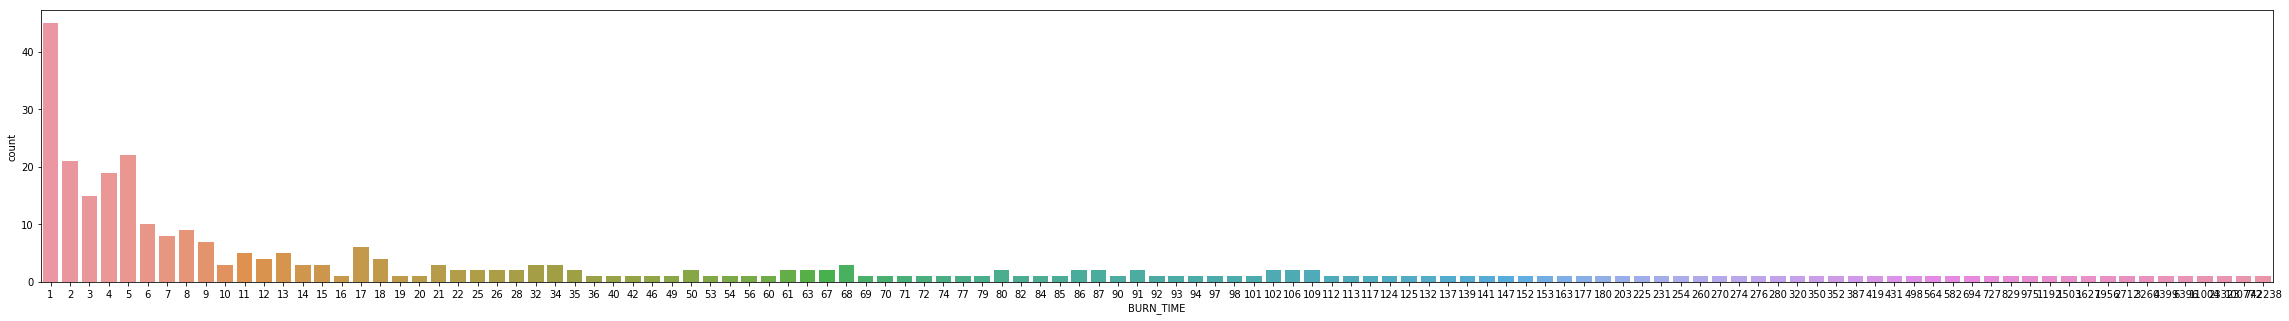

In [34]:
fig, ax = plt.subplots(figsize=(40,5))
sns.countplot(x=df_all['BURN_TIME'].value_counts(), data=df_all)

I'm going to make a new column to use as my target, "Arson". If the cause was arson the value will be 1, else 0.

In [35]:
# the below works but it isn't vectorized and it takes a hot minute. Going to try to do something faster for practice.

# def make_arson(dataframe):
#     if dataframe['STAT_CAUSE_DESCR'] == 'Arson':
#         val = 1
#     else:
#         val = 0
#     return val
#
#
# df_all['ARSON'] = df_all.apply(make_arson, axis=1)

In [36]:
#humbug. df_all['ARSON'] = [x for x in df_all['STAT_CAUSE_DESCR'] if x =='Arson' x = 1 else 0]

In [37]:
df_all.loc[df_all['STAT_CAUSE_DESCR'] != 'Arson', 'ARSON'] = 0
df_all.loc[df_all['STAT_CAUSE_DESCR'] == 'Arson', 'ARSON'] = 1

df_all.head(3)

,FIRE_CODE,DISCOVERY_DOY,STAT_CAUSE_DESCR,FIRE_SIZE,STATE,FIPS_CODE,START_DATE,BURN_TIME,MONTH,DOW,ARSON
0,BJ8K,33,Miscellaneous,0.10,CA,063,2005-02-02,0.0,2,Wednesday,0.0
1,AAC0,133,Lightning,0.25,CA,061,2004-05-12,0.0,5,Wednesday,0.0
2,A32W,152,Debris Burning,0.10,CA,017,2004-05-31,0.0,5,Monday,0.0


Wow that was a lot faster.

In [38]:
df_all['ARSON'] = df_all['ARSON'].astype(int)

Now That I've made the target column for arson I can drop the original column.

In [39]:
df_all.head()

,FIRE_CODE,DISCOVERY_DOY,STAT_CAUSE_DESCR,FIRE_SIZE,STATE,FIPS_CODE,START_DATE,BURN_TIME,MONTH,DOW,ARSON
0,BJ8K,33,Miscellaneous,0.10,CA,063,2005-02-02,0.0,2,Wednesday,0
1,AAC0,133,Lightning,0.25,CA,061,2004-05-12,0.0,5,Wednesday,0
2,A32W,152,Debris Burning,0.10,CA,017,2004-05-31,0.0,5,Monday,0
3,None,180,Lightning,0.10,CA,003,2004-06-28,5.0,6,Monday,0
4,None,180,Lightning,0.10,CA,003,2004-06-28,5.0,6,Monday,0


In [40]:
df_all.drop(['STAT_CAUSE_DESCR'], axis=1, inplace=True)

In [41]:
df_all.ARSON.value_counts()

0    1432287
1     281455
Name: ARSON, dtype: int64

In [42]:
281455/1713742

0.164234172938517

16.42% of these fires were started by arsonists! Crazy. Also: that's a pretty unbalanced class. Hopefully that won't cause problems. Famous last words.

Over half of all the FIRE_CODE entries are nulls. DROPPED.

In [43]:
df_all.drop(['FIRE_CODE'], axis=1, inplace=True)

In [44]:
df_all.isnull().sum()

DISCOVERY_DOY         0
FIRE_SIZE             0
STATE                 0
FIPS_CODE        636349
START_DATE            0
BURN_TIME        796359
MONTH                 0
DOW                   0
ARSON                 0
dtype: int64

I'm going to drop FIPS, because I think State will cover location and going all the way down to county risks overfitting on historic data. A county may have an arsonist in it for a time who may have been arrested, moved or died; using a coefficient for that county that was affected while the arsonist was acitive will decrease accuracy. This is also true in a state but given the differences in population between states and differenes in weather conditions I think it will be predictive and have a lower risk of over fitting.

In [45]:
df_all.drop(['FIPS_CODE'], axis=1, inplace=True)

In [46]:
df_all.head(3)

,DISCOVERY_DOY,FIRE_SIZE,STATE,START_DATE,BURN_TIME,MONTH,DOW,ARSON
0,33,0.10,CA,2005-02-02,0.0,2,Wednesday,0
1,133,0.25,CA,2004-05-12,0.0,5,Wednesday,0
2,152,0.10,CA,2004-05-31,0.0,5,Monday,0


In [47]:
df_all.dtypes

DISCOVERY_DOY             int64
FIRE_SIZE               float64
STATE                    object
START_DATE       datetime64[ns]
BURN_TIME               float64
MONTH                     int64
DOW                      object
ARSON                     int64
dtype: object

I don't really need to do this because I'm going to label encode and then one-hot encode it later but that will make just doing one loop for all the things that need encoding simpler, if a little more time consuming to run. Worth it.

In [48]:
df_all['MONTH'] = df_all['MONTH'].apply(lambda x: calendar.month_name[x])

Whoops, ran it twice.

In [49]:
df_all.head(2)

,DISCOVERY_DOY,FIRE_SIZE,STATE,START_DATE,BURN_TIME,MONTH,DOW,ARSON
0,33,0.10,CA,2005-02-02,0.0,February,Wednesday,0
1,133,0.25,CA,2004-05-12,0.0,May,Wednesday,0


After much consideration I am going to drop the start date, keep the day-of-year, but transform it to be cyclic so the algorithms can see that 1 and 365 are actually closer than 60 and 365.

In [50]:
df_all.drop(['START_DATE'], axis=1, inplace=True)

I need to encode my categorical values. I can use one-hot encoding or get dummies and drop one column. For month and day-of-week there are only 12 and 7 categories, respectively, so for them I'll get dummies. For the other 2 I'll use one-hot because there are so categories and I don't want to dataframe that big considering how much modeling I'm doing, the ram required would get too big.

Now I'm going to try impute data for BURN_TIME. I want to test to see if the data is missing at random. I'm going to check for a correlation between BURN_TIME and the other features.

In [51]:
df_all.head(2)

,DISCOVERY_DOY,FIRE_SIZE,STATE,BURN_TIME,MONTH,DOW,ARSON
0,33,0.10,CA,0.0,February,Wednesday,0
1,133,0.25,CA,0.0,May,Wednesday,0


In this notebook I'm going to just drop the missing burn time values and then include it in my analysis. See what that gets me.

In [52]:
df_wburn = df_all.drop(df_all[df_all['BURN_TIME'].isnull() == True].index)

In [53]:
df_wburn.head(20)

,DISCOVERY_DOY,FIRE_SIZE,STATE,BURN_TIME,MONTH,DOW,ARSON
0,33,0.10,CA,0.0,February,Wednesday,0
1,133,0.25,CA,0.0,May,Wednesday,0
2,152,0.10,CA,0.0,May,Monday,0
3,180,0.10,CA,5.0,June,Monday,0
4,180,0.10,CA,5.0,June,Monday,0
5,182,0.10,CA,1.0,June,Wednesday,0
6,183,0.10,CA,1.0,July,Thursday,0
7,67,0.80,CA,0.0,March,Tuesday,0
8,74,1.00,CA,0.0,March,Tuesday,0
9,183,0.10,CA,1.0,July,Thursday,0


In [54]:
df_wburn.shape

(917383, 7)

In [55]:
df_wburn.isnull().sum()

DISCOVERY_DOY    0
FIRE_SIZE        0
STATE            0
BURN_TIME        0
MONTH            0
DOW              0
ARSON            0
dtype: int64

In [56]:
df_wburn.dtypes

DISCOVERY_DOY      int64
FIRE_SIZE        float64
STATE             object
BURN_TIME        float64
MONTH             object
DOW               object
ARSON              int64
dtype: object

I want to make the DISCOVERED_DOY cyclic.

In [57]:
df_wburn['DOY_SIN'] = np.sin(df_wburn.DISCOVERY_DOY*(2.*np.pi/365))
df_wburn['DOY_COS'] = np.cos(df_wburn.DISCOVERY_DOY*(2.*np.pi/365))

In [58]:
df_wburn.head(2)

,DISCOVERY_DOY,FIRE_SIZE,STATE,BURN_TIME,MONTH,DOW,ARSON,DOY_SIN,DOY_COS
0,33,0.10,CA,0.0,February,Wednesday,0,0.538005,0.842942
1,133,0.25,CA,0.0,May,Wednesday,0,0.752667,-0.658402


In [59]:
df_wburn = df_wburn.drop(['DISCOVERY_DOY'], axis=1)

In [60]:
df_wburn['BURN_TIME'] = df_wburn['BURN_TIME'].astype(int)

In [61]:
df_wburn.head(2)

,FIRE_SIZE,STATE,BURN_TIME,MONTH,DOW,ARSON,DOY_SIN,DOY_COS
0,0.10,CA,0,February,Wednesday,0,0.538005,0.842942
1,0.25,CA,0,May,Wednesday,0,0.752667,-0.658402


I need to scale this. There are a ton of outliers so I'm going to use RobustScaler.

In [62]:
#robsca = RobustScaler()

In [63]:
#df_wburn['BURN_TIME'] = robsca.fit_transform(df_wburn['BURN_TIME'].values.reshape(-1, 1))

In [64]:
#df_wburn.head(10)

Turns out that with all the zeros in BURN_TIME it's a sparse matrix so robust scalar won't work. Sparse data often calls for MaxAbsScaler but that scales by the highest absolute value, and since there are outliers in both BURN_TIME and FIRE_SIZE I don't want to do that.

In [65]:
ss = StandardScaler()

In [66]:
df_wburn['BURN_TIME'] = ss.fit_transform(df_wburn['BURN_TIME'].values.reshape(-1, 1))

/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [67]:
df_wburn.head(3)

,FIRE_SIZE,STATE,BURN_TIME,MONTH,DOW,ARSON,DOY_SIN,DOY_COS
0,0.10,CA,-0.081338,February,Wednesday,0,0.538005,0.842942
1,0.25,CA,-0.081338,May,Wednesday,0,0.752667,-0.658402
2,0.10,CA,-0.081338,May,Monday,0,0.501242,-0.865307


(array([9.17055e+05, 1.90000e+02, 6.60000e+01, 3.00000e+01, 1.80000e+01,
        1.00000e+01, 4.00000e+00, 4.00000e+00, 4.00000e+00, 2.00000e+00]),
 array([1.00000000e-04, 6.06945001e+04, 1.21389000e+05, 1.82083500e+05,
        2.42778000e+05, 3.03472500e+05, 3.64167000e+05, 4.24861500e+05,
        4.85556000e+05, 5.46250500e+05, 6.06945000e+05]),
 <a list of 10 Patch objects>)

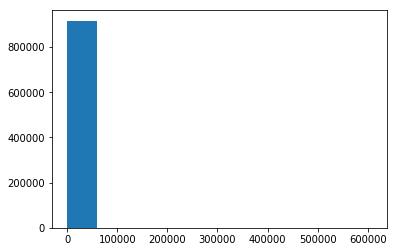

In [68]:
plt.hist(df_wburn.FIRE_SIZE)

In [69]:
robsca = RobustScaler()

In [70]:
df_wburn['FIRE_SIZE'] = robsca.fit_transform(df_wburn['FIRE_SIZE'].values.reshape(-1, 1))

In [71]:
df_wburn.head(3)

,FIRE_SIZE,STATE,BURN_TIME,MONTH,DOW,ARSON,DOY_SIN,DOY_COS
0,-0.142857,CA,-0.081338,February,Wednesday,0,0.538005,0.842942
1,-0.089286,CA,-0.081338,May,Wednesday,0,0.752667,-0.658402
2,-0.142857,CA,-0.081338,May,Monday,0,0.501242,-0.865307


OKAY. Now everything that needed to be is scaled and normalized. Time to encode my categorical values.

THE BELOW WAS THE ORIGINAL PLAN BUT I SWITCHED TO ONE-HOT ENCODING EVERYTHING AND USING PCA TO REDUCE DIMENSIONALITY.

I need to drop 1 dummy variable for each of the features I just got dummies from. I'm choosing Wednesday because it's the middle of the weekdays, of which there are 5 vs just 2 weekends (I believe that the ratio of causes that fires started on weekend days had will be different from weekdays. I am hoping this will help with interpretation.) I'm choosing January essentially at random, it's the first value which is what get_dummies has as a parameter.

In [72]:
# categorical_vars=['MONTH','DOW']
# for var in categorical_vars:
#     cat_list='var'+'_'+var
#     cat_list = pd.get_dummies(df_all[var], prefix=var, drop_first=False)
#     df_all1=df_all.join(cat_list)
#     df_all=df_all1

#DECIDED TO DO ONE-HOT ENCODING ON EVERYTHING AND THEN USE PCA TO DEAL WITH THE COLLINIERITY PROBLEM.

In [73]:
lab_enc = LabelEncoder()
oh_enc = OneHotEncoder()

need_encoding = [df_wburn['STATE'], df_wburn['MONTH'], df_wburn['DOW']]

for feat in need_encoding:
    feat_int_encoded = lab_enc.fit_transform(feat)
    feat_int_encoded_reshape = feat_int_encoded.reshape(len(feat_int_encoded), 1) 
    feat_onehot_encoded = oh_enc.fit_transform(feat_int_encoded_reshape)
    df_feat = pd.DataFrame(feat_onehot_encoded.toarray())
    df_wburn2 = df_wburn.join(df_feat, lsuffix='_STATE')
    df_wburn = df_wburn2

df_wburn.shape

,FIRE_SIZE,STATE,BURN_TIME,MONTH,DOW,ARSON,DOY_SIN,DOY_COS,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,...,51,0_y,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y,10_y,11_y,0,1,2,3,4,5,6
0,-0.142857,CA,-0.081338,February,Wednesday,0,0.538005,0.842942,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.089286,CA,-0.081338,May,Wednesday,0,0.752667,-0.658402,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.142857,CA,-0.081338,May,Monday,0,0.501242,-0.865307,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
lab_enc = LabelEncoder()
# oh_enc = OneHotEncoder()

# need_encoding = [df_wburn['STATE'], df_wburn['MONTH'], df_wburn['DOW']]

# for feat in need_encoding:
#     if feat.nunique() == 52:
#         feat_int_encoded1 = lab_enc.fit_transform(feat)
#         feat_int_encoded_reshape1 = feat_int_encoded.reshape(len(feat_int_encoded1), 1) 
#         feat_onehot_encoded1 = oh_enc.fit_transform(feat_int_encoded_reshape1)
#         df_feat1 = pd.DataFrame(feat_onehot_encoded1.toarray())
#     elif feat.nunique() == 12:
#         feat_int_encoded2 = lab_enc.fit_transform(feat)
#         feat_int_encoded_reshape2 = feat_int_encoded2.reshape(len(feat_int_encoded2), 1) 
#         feat_onehot_encoded2 = oh_enc.fit_transform(feat_int_encoded_reshape2)
#         df_feat2 = pd.DataFrame(feat_onehot_encoded2.toarray())
#     else:
#         feat_int_encoded3 = lab_enc.fit_transform(feat)
#         feat_int_encoded_reshape3 = feat_int_encoded3.reshape(len(feat_int_encoded3), 1) 
#         feat_onehot_encoded3 = oh_enc.fit_transform(feat_int_encoded_reshape3)
#         df_feat3 = pd.DataFrame(feat_onehot_encoded3.toarray())
        
#     df_wburn2 = df_wburn.join(df_feat1, lsuffix='state')
#     df_wburn3 = df_wburn2.join(df_feat2, lsuffix='month')
#     df_wburn4 = df_wburn3.join(df_feat3, lsuffix='DOW')
#     df_wburn = df_wburn2


# df_wburn.shape

In [74]:
df_wburn.drop(['STATE', 'MONTH', 'DOW'], axis=1, inplace=True)

In [75]:
df_wburn.head(3)

,FIRE_SIZE,BURN_TIME,ARSON,DOY_SIN,DOY_COS,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12,13,14,...,51,0_y,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y,10_y,11_y,0,1,2,3,4,5,6
0,-0.142857,-0.081338,0,0.538005,0.842942,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.089286,-0.081338,0,0.752667,-0.658402,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.142857,-0.081338,0,0.501242,-0.865307,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [76]:
print(np.corrcoef(df_wburn['FIRE_SIZE'], df_wburn['BURN_TIME']))

[[1.         0.10817263]
 [0.10817263 1.        ]]


That's a nice looking dataframe for machine learning. To deal with the all that dimensionality and collinearity I'm going to use PCA.

In [77]:
for i in df_wburn.columns:
    print(np.corrcoef(df_wburn['ARSON'], df_wburn[i])[0,1])

-0.010100877386780513
-0.023102169599927037
1.0
0.21727872292443232
0.3115484700279111
0.018262222238848536
0.039750388367940176
0.09234319543058922
-0.023448552170872477
-0.028585804049148053
-0.038358198490938356
0.04414804261212062
-0.0043735601674318204
0.002089869300088419
0.015387611751889086
-0.007544983977943376
-0.002833841770124099
-0.006207201335102621
-0.04573696186666396
0.009041418452971026
0.0008678580778531611
0.0075746752028741865
0.02302926050302347
0.006669754393826193
-0.0042819847460168325
-0.003820122585716424
-0.0008924848500804302
-0.0014564729630694448
0.006206584380532809
0.029675375099844036
0.014057449654639308
-0.004405156951236721
0.016052455924338804
0.15458228132582866
-0.016731038442698968
-0.004215565954191046
-0.004344067365684064
-0.03536682058484418
-0.051957535481826925
0.08366511856913765
-0.0056540067760405405
0.08826292930378975
-0.0678325984051731
0.006721937734572639
-0.003434609711863092
0.011456247222251885
0.007515007526637829
-0.0179131391

In [78]:
df_nosin = df_wburn.drop(['DOY_SIN'], axis=1)

In [79]:
df_nosin.head(3)

,FIRE_SIZE,BURN_TIME,ARSON,DOY_COS,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12,13,14,15,...,51,0_y,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y,10_y,11_y,0,1,2,3,4,5,6
0,-0.142857,-0.081338,0,0.842942,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.089286,-0.081338,0,-0.658402,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.142857,-0.081338,0,-0.865307,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [80]:
pca_nosin = PCA()
pca_nosin.fit(df_nosin.drop(['ARSON'], axis=1))

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [81]:
var_exp_nosin = pca_nosin.explained_variance_ratio_
cum_var_exp_nosin = np.cumsum(var_exp_nosin)

In [82]:
len(pca_nosin.components_)

74

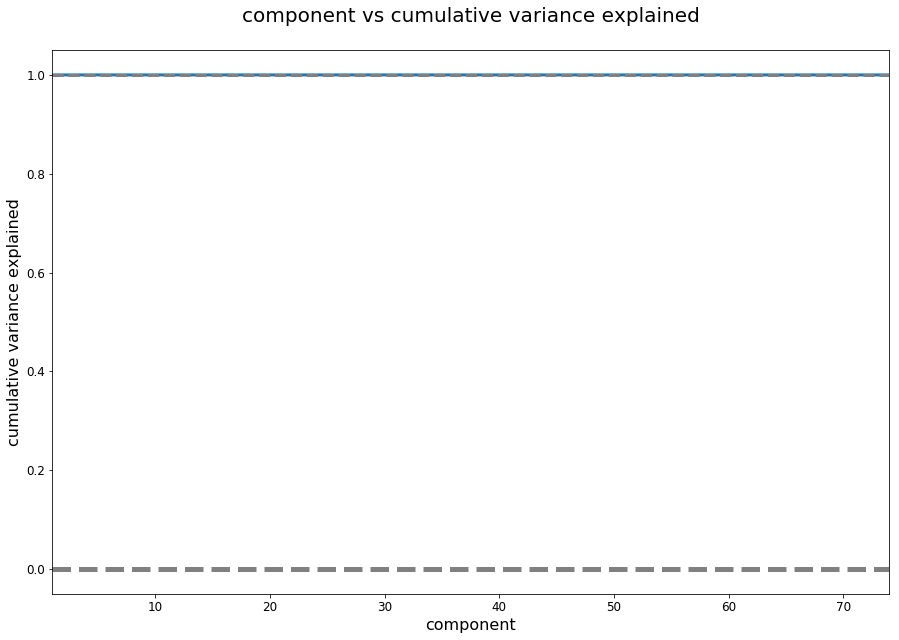

In [83]:
plt.figure(figsize=(15,10))

# HERE IS THE BASIC PLOT

# Plot the cumulative explained variance
component_number = list(range(1, 75))
plt.plot(component_number, cum_var_exp_nosin, lw=3)

# NOW MAKE IT LOOK PRETTY

# Add horizontal lines at y=0 and y=100
plt.axhline(y=0, linewidth=5, color='grey', ls='dashed')
plt.axhline(y=1, linewidth=3, color='grey', ls='dashed')

# Set the x and y axis limits
ax = plt.gca()
ax.set_xlim([1,74])
ax.set_ylim([-0.05,1.05])

# Label the axes
ax.set_ylabel('cumulative variance explained', fontsize=16)
ax.set_xlabel('component', fontsize=16)

# Make the tick labels bigger
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
# Add title
ax.set_title('component vs cumulative variance explained\n', fontsize=20)

plt.show()

In [84]:
print(cum_var_exp_nosin)

[0.99999807 0.99999862 0.99999877 0.99999887 0.99999895 0.99999902
 0.99999909 0.99999915 0.99999922 0.99999928 0.99999935 0.99999941
 0.99999946 0.99999951 0.99999955 0.99999959 0.99999962 0.99999965
 0.99999968 0.99999971 0.99999973 0.99999975 0.99999977 0.99999979
 0.99999981 0.99999982 0.99999984 0.99999985 0.99999986 0.99999988
 0.99999989 0.9999999  0.99999991 0.99999991 0.99999992 0.99999993
 0.99999994 0.99999994 0.99999995 0.99999995 0.99999996 0.99999996
 0.99999997 0.99999997 0.99999998 0.99999998 0.99999998 0.99999999
 0.99999999 0.99999999 0.99999999 0.99999999 0.99999999 0.99999999
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.        ]


In [85]:
pca_wburn = PCA()
pca_wburn.fit(df_wburn.drop(['ARSON'], axis=1))

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

The next few cells are from the PCA lesson.

In [86]:
var_exp_wburn = pca_wburn.explained_variance_ratio_
cum_var_exp_wburn = np.cumsum(var_exp_wburn)

In [87]:
len(pca_wburn.components_)

75

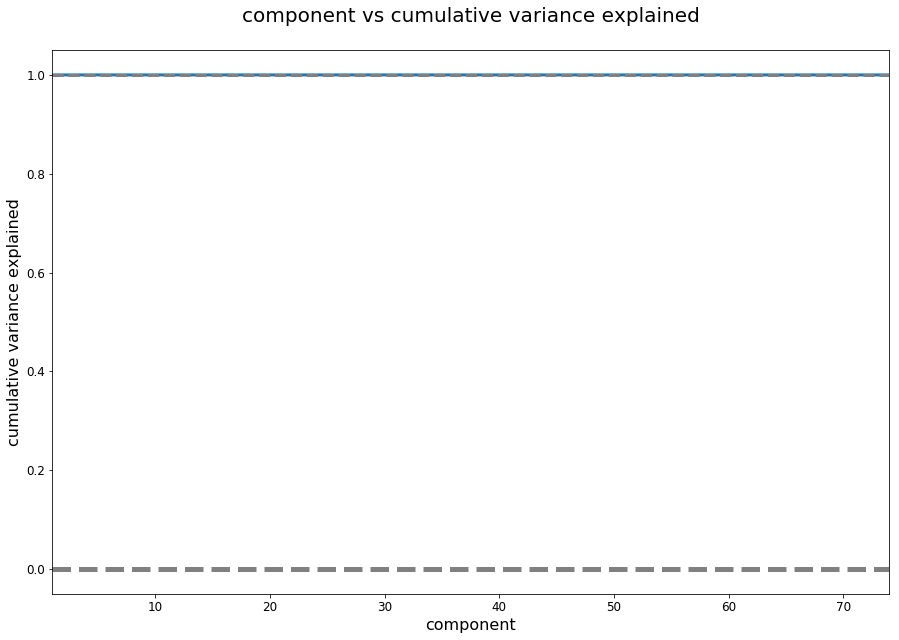

In [88]:
plt.figure(figsize=(15,10))

# HERE IS THE BASIC PLOT

# Plot the cumulative explained variance
component_number = list(range(1, 76))
plt.plot(component_number, cum_var_exp_wburn, lw=3)

# NOW MAKE IT LOOK PRETTY

# Add horizontal lines at y=0 and y=100
plt.axhline(y=0, linewidth=5, color='grey', ls='dashed')
plt.axhline(y=1, linewidth=3, color='grey', ls='dashed')

# Set the x and y axis limits
ax = plt.gca()
ax.set_xlim([1,74])
ax.set_ylim([-0.05,1.05])

# Label the axes
ax.set_ylabel('cumulative variance explained', fontsize=16)
ax.set_xlabel('component', fontsize=16)

# Make the tick labels bigger
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    
# Add title
ax.set_title('component vs cumulative variance explained\n', fontsize=20)

plt.show()

I don't trust that result at all. But I have tried a bunch of different ways to catch something going wrong with it. I dropped one of my cyclical DOY columns - nothing. I scaled and normalized both my numeric columns: fire size and burn time - nothing. I checked the corrcoeffs of each feature against Arson: the biggest one is 0.3 - nothing there either. I checked to see what the correlation between BURN_TIME and FIRE_SIZE is, it's 0.1 - nothing. I have looked over the code, which is quite simple and would be hard to screw up in such a way that it would still run, several times and found no errors. I suppose it's possible that something extraordinarily improbable has occurred here.

In [89]:
print(cum_var_exp_wburn)

[0.99999786 0.99999842 0.99999864 0.99999878 0.99999888 0.99999895
 0.99999902 0.99999909 0.99999916 0.99999922 0.99999929 0.99999935
 0.99999941 0.99999947 0.99999951 0.99999955 0.99999959 0.99999962
 0.99999965 0.99999968 0.99999971 0.99999973 0.99999975 0.99999977
 0.99999979 0.99999981 0.99999982 0.99999984 0.99999985 0.99999987
 0.99999988 0.99999989 0.9999999  0.99999991 0.99999991 0.99999992
 0.99999993 0.99999994 0.99999994 0.99999995 0.99999995 0.99999996
 0.99999996 0.99999997 0.99999997 0.99999998 0.99999998 0.99999998
 0.99999999 0.99999999 0.99999999 0.99999999 0.99999999 0.99999999
 0.99999999 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.        ]


I'll keep 4 of my pca components for now. That keeps 99.999984% of my variance explained while dropping almost all of my variables. This solves the problems of multi-collinearity and the high dimensionality my data had after one-hot encoding. It also is going to make everything run much faster. After I've gotten to the point where I'm scoring models I'll try a few other numbers of PCA features to use, all low to keep my dimensionality down.

**UPDATE:** Setled on 6 PCA features after looking at scores for a bunch of different numbers under 10.

Time to make my training and testing sets. Then I'll transform with PCA and use that.

In [90]:
X = df_wburn.drop(['ARSON'], axis=1)
y = df_wburn['ARSON']

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [92]:
pca_6 = PCA(n_components=6)
pca_6.fit(X_train)
Xt_train = pca_6.transform(X_train)
Xt_test = pca_6.transform(X_test)

About half of the code for these models came from : http://scikit-learn.org/stable/auto_examples/ensemble/plot_feature_transformation.html#sphx-glr-auto-examples-ensemble-plot-feature-transformation-py

In [93]:
lr = LogisticRegression()
lr.fit(Xt_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [94]:
lr.score(Xt_test, y_test)

0.8558191654717868

In [95]:
n_estimator = 10

In [96]:
rt = RandomTreesEmbedding(max_depth=4, n_estimators=n_estimator,
    random_state=42)

rt_lm = LogisticRegression()
pipeline = make_pipeline(rt, rt_lm)
pipeline.fit(Xt_train, y_train)

Pipeline(memory=None,
     steps=[('randomtreesembedding', RandomTreesEmbedding(max_depth=4, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           random_state=42, sp...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [97]:
pipeline.score(Xt_test, y_test)

0.8556745749641536

In [98]:
rf = RandomForestClassifier(max_depth=4, n_estimators=n_estimator)
rf.fit(Xt_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [99]:
rf.score(Xt_test, y_test)

0.8600363886110877

In [100]:
grd = GradientBoostingClassifier(n_estimators=n_estimator)
grd.fit(Xt_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [101]:
grd.score(Xt_test, y_test)

0.8558191654717868

In [102]:
xgb = XGBClassifier()
xgb.fit(Xt_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [103]:
xgb.score(Xt_test, y_test)

/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8619401636282578

In [104]:
gnb = GaussianNB()
gnb.fit(Xt_train, y_train)

GaussianNB(priors=None)

In [105]:
gnb.score(Xt_test, y_test)

0.7476534165532033

In [106]:
pca2 = PCA(n_components=2)
pca2.fit(X_train)
Xt_train_svc = pca2.transform(X_train)
Xt_test_svc = pca2.transform(X_test)

In [151]:
lsvc = LinearSVC(fit_intercept=False, random_state=42)
lsvc.fit(Xt_train_svc, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=False,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

In [154]:
calclass_lsvc = CalibratedClassifierCV(lsvc, cv=2, method='sigmoid')
calclass_lsvc.fit(Xt_train_svc, y_train)

/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/calibration.py:435: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/calibration.py:445: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/calibration.py:447: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)
/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/calibration.py:435: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/calibration.py:435: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/Users/ryanmetz/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/calibration.py:445: R

CalibratedClassifierCV(base_estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=False,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0),
            cv=2, method='sigmoid')

In [ ]:
lsvc_preds = lsvc.predict(Xt_test_svc)
lsvc_pred_probas = lsvc.decision_function(Xt_test_svc) 

The below cell was run and an ROC curve was generated below. It was terrible so I commented this all out so it wouldn't be re-run if I end up restarting this kernel and going through everything again.

In [ ]:
# Xt_train_small, Xt_train_lr, y_train_small, y_train_lr = train_test_split(Xt_train,
#                                                             y_train,
#                                                             test_size=0.5)

# grd_enc_lm = GradientBoostingClassifier(n_estimators=n_estimator)
# grd_lm = LogisticRegression()
# grd_enc = OneHotEncoder()

# grd.fit(Xt_train_small, y_train_small)
# grd_enc.fit(grd.apply(Xt_train_small)[:, :, 0])
# grd_lm.fit(grd_enc.transform(grd.apply(Xt_train_lr)[:, :, 0]), y_train_lr)

In [ ]:
# clf = SVC()
# clf.fit(Xt_train, y_train) commented out because this takes waaaaay to long to run on my laptop.

In [ ]:
#clf.score(Xt_test, y_test)

In [ ]:
# commented out because I'm using roc2() from now on

# def roc(probas, true, step=0.01):
    
#     probas = probas[:,1]  
#     true = true.values 
#     assert(len(probas) == len(true))
    
#     TPRs = [] # Setting up empty list of True Positive Rate
#     FPRs = [] # Setting up empty list of False Positive Rate
    
#     for i in np.arange(0.0,1.0,step): # np.arange allows us to use step sizes that are decimals
#         preds_class = probas > i # Numpy arrays have a feature called 'broadcasting.' Check the documentation: https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html to see what this does.
#         TP = 0 
#         FP = 0
#         TN = 0
#         FN = 0
#         for index in range(len(preds_class)): # We're comparing each prediction with each true value here

#             if preds_class[index] == 1 and true[index] == 1:
#                 TP += 1
#             elif preds_class[index] == 1 and true[index] == 0:
#                 FP += 1
#             elif preds_class[index] == 0 and true[index] == 0:
#                 TN += 1 
#             elif preds_class[index] == 0 and true[index] == 1:
#                 FN += 1
                
#         TPR = TP/(TP + FN) # Calculating TPR and FPR and appending to our lists
#         FPR = FP/(FP + TN)
        
#         TPRs.append(TPR)
#         FPRs.append(FPR)
         
#     plt.rcParams['font.size'] = 14
#     plt.plot(FPRs, TPRs, color="orange")
#     plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.0])
#     plt.title('Receiver Operating Characteristic')
#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate")
#     plt.show();

In [ ]:
roc(lr.predict_proba(Xt_test), y_test)

In [ ]:
roc(pipeline.predict_proba(Xt_test), y_test)

In [ ]:
roc(rf.predict_proba(Xt_test), y_test)

In [ ]:
roc(grd.predict_proba(Xt_test), y_test)

In [ ]:
roc(xgb.predict_proba(Xt_test), y_test)

In [ ]:
#commented out so it can't be run again. This was terrible so I'm not going to use it, but if I go back and run
#everything again I don't want to spend the few minutes this took to run, but I don't want to lose the graph.
#roc(grd_lm.predict_proba(grd_enc.transform(grd.apply(X_test)[:, :, 0])), y_test)

Wow definitely don't use that one. I'm going to comment that out above.

The code in the next 2 cells also comes from a GA lesson.

In [107]:
def roc2(probas, true, step=0.01, plot=True):
    """
    probas should be a numpy array of predict_probas
    true is a pandas series of true labels
    step is the step size for checking thresholds
    plot is a boolean for whether we want to generate a plot
    """
    
    probas = probas[:,1]  # The output of predict_proba() is an array of the probabilities for every class, but we only want the probabilities for class 1
    true = true.values    # We need to convert the class labels from a Pandas Series to a numpy array. We do this using the .values attribute
    assert(len(probas) == len(true)) # We're making sure that our probabilities vector is the same length as our true class labesl vector
    
    TPRs = [] # Setting up empty list of True Positive Rate
    FPRs = [] # Setting up empty list of False Positive Rate
    
    for i in np.arange(0.0,1.0,step): # np.arange allows us to use step sizes that are decimals
        preds_class = probas > i # Numpy arrays have a feature called 'broadcasting.' Check the documentation: https://docs.scipy.org/doc/numpy-1.13.0/user/basics.broadcasting.html to see what this does.
        TP = 0 
        FP = 0
        TN = 0
        FN = 0
        for index in range(len(preds_class)): # We're comparing each prediction with each true value here

            if preds_class[index] == 1 and true[index] == 1:
                TP += 1
            elif preds_class[index] == 1 and true[index] == 0:
                FP += 1
            elif preds_class[index] == 0 and true[index] == 0:
                TN += 1 
            elif preds_class[index] == 0 and true[index] == 1:
                FN += 1
                
        TPR = TP/(TP + FN) # Calculating TPR and FPR and appending to our lists
        FPR = FP/(FP + TN)
        
        TPRs.append(TPR)
        FPRs.append(FPR)
        
    if plot: # Only generate a plot if plot == True
        
        plt.rcParams['font.size'] = 14
        plt.plot(FPRs, TPRs, color="orange")
        plt.plot([0,1],[0,1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.title('Receiver Operating Characteristic')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.show();
        
    return np.array(TPRs), np.array(FPRs) # We'll neet to have our TPRs and FPRs as arrays so we can use broadcasting in the next function.

def sen_spec(probas, true, stat="sensitivity", stat_val=0.5, step=0.01):
    '''
    This is the function that the assignment is asking for. We'll feed in our probas and true vectors as we do with the previous function, as well
    as we are looking at, as well as the value of that stat that we want to find, and the step size for our roc function.
    
    '''
    
    stat = stat.lower() # turn the string into lowercase for ease of comparison
    
    assert(stat in ["sensitivity", "specificity"]) # Throw an error if the user did not write sensitivity or specificity
    
    TPRs, FPRs = roc2(probas, true, step=step, plot=False) # use our roc function to get vectors of TPR and FPR
    
    if stat == "sensitivity":
        diffs = np.absolute(TPRs - stat_val) # We won't necessarily be able to find a threshold that gives the exact value we're looking for, but we can find the one that gets us the closest.
        loc = np.argmin(diffs) # We want to find the index of the TPR that was closest to the value we specified
        threshold = loc * step
        sensitivity = TPRs[loc]
        spec_corr = (1 - FPRs[loc])
        
        print("Sensitivity: {:.5f}%, Specificity: {:.5f}%, Threshold: {}%".format(sensitivity*100, spec_corr*100, threshold*100))
        return TPRs, FPRs
    
    elif stat == "specificity":
        specificities = 1 - FPRs # FPR = 1 - specificity --> specificity = 1 - FPR
        diffs = np.absolute(specificities - stat_val)
        loc = np.argmin(diffs)
        threshold = loc * step
        specificity = specificities[loc]
        sens_corr = (TPRs[loc])
        
        print("Specificity: {:.5f}%, Sensitivity: {:.5f}%, Threshold: {}%".format(specificity*100, sens_corr*100, threshold*100))
        return TPRs, FPRs

In [108]:
def auc(y, x):
    
    auc = 0
    for i in range(1,len(x)):
        auc += ((y[i] + y[i-1])/2)*abs((x[i] - x[i-1]))
        
    return auc

Going to re-run all the models for scoring with the above functions.

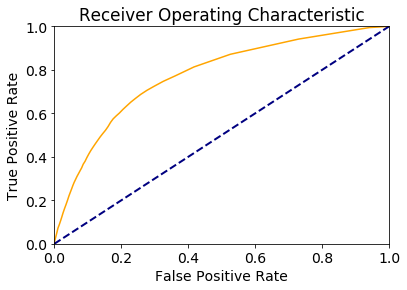

(array([1.00000000e+00, 9.99498579e-01, 9.99247869e-01, 9.98913589e-01,
        9.98245028e-01, 9.94484372e-01, 9.41500919e-01, 8.71552733e-01,
        8.13471503e-01, 7.72605716e-01, 7.47200401e-01, 7.24385760e-01,
        7.05582484e-01, 6.87113488e-01, 6.69062343e-01, 6.51763329e-01,
        6.33712185e-01, 6.17666722e-01, 6.01537690e-01, 5.88584322e-01,
        5.74628113e-01, 5.58582651e-01, 5.38943674e-01, 5.22313221e-01,
        5.06936320e-01, 4.91559418e-01, 4.75096106e-01, 4.59050643e-01,
        4.43590172e-01, 4.28547551e-01, 4.13003510e-01, 3.96707337e-01,
        3.79575464e-01, 3.65619255e-01, 3.49155942e-01, 3.36620425e-01,
        3.22664215e-01, 3.09877988e-01, 2.96673909e-01, 2.82299850e-01,
        2.68009360e-01, 2.52131038e-01, 2.36085576e-01, 2.20207254e-01,
        2.00735417e-01, 1.81180010e-01, 1.62293164e-01, 1.42487047e-01,
        1.24686612e-01, 1.06551897e-01, 8.85007521e-02, 7.24552900e-02,
        4.98913589e-02, 2.83302691e-02, 1.46247702e-02, 5.264917

In [109]:
roc2(lr.predict_proba(Xt_test), y_test)

In [ ]:
#TPRs_lr, FPRs_lr = sen_spec(probas=lr.predict_proba(Xt_test), true=y_test, stat="specificity", stat_val = 0.99, step=0.01)
#this was with 5 pca feats


In [ ]:
#TPRs_lr, FPRs_lr = sen_spec(probas=lr.predict_proba(Xt_test), true=y_test, stat="specificity", stat_val = 0.99, step=0.01)
# 7 PCA feats

In [ ]:
#TPRs_lr, FPRs_lr = sen_spec(probas=lr.predict_proba(Xt_test), true=y_test, stat="specificity", stat_val = 0.99, step=0.01)
# 8 pca feats

A "by-hand gridsearch" shows that 6 PCA features gives the best sensitivity. Could be a local maxima but I'm not willing to make the data array even bigger than 8 given how many rows I have.

In [126]:
TPRs_lr, FPRs_lr = sen_spec(probas=lr.predict_proba(Xt_test), true=y_test, stat="specificity", stat_val = 0.99, step=0.01)
#with 6 pca feats

Specificity: 98.90746%, Sensitivity: 7.25389%, Threshold: 51.0%


In [110]:
auc(TPRs_lr, FPRs_lr)

NameError: name 'TPRs_lr' is not defined

This "pipeline" was a random trees embedding with a logistic regression performed on that output.

In [ ]:
roc2(pipeline.predict_proba(Xt_test), y_test)

In [ ]:
TPRs_rt, FPRs_rt = sen_spec(probas=pipeline.predict_proba(Xt_test), true=y_test, stat="specificity", stat_val = 0.99, step=0.01)


In [ ]:
auc(TPRs_rt, FPRs_rt)

Now for the random forest.

In [ ]:
roc2(rf.predict_proba(Xt_test), y_test)

In [ ]:
TPRs_rf, FPRs_rf = sen_spec(probas=rf.predict_proba(Xt_test), true=y_test, stat="specificity", stat_val = 0.99, step=0.01)


In [ ]:
auc(TPRs_rf, FPRs_rf)

Next is Gradient Boosted Trees Classifier

In [ ]:
roc2(grd.predict_proba(Xt_test), y_test)

In [ ]:
TPRs_grd, FPRs_grd = sen_spec(probas=grd.predict_proba(Xt_test), true=y_test, stat="specificity", stat_val = 0.99, step=0.01)


In [ ]:
auc(TPRs_grd, FPRs_grd)

Now for XGBoost

In [ ]:
roc2(xgb.predict_proba(Xt_test), y_test)

In [ ]:
TPRs_xgb, FPRs_xgb = sen_spec(probas=xgb.predict_proba(Xt_test), true=y_test, stat="specificity", stat_val = 0.99, step=0.01)


In [ ]:
auc(TPRs_xgb, FPRs_xgb)

Now Gaussian Naive Bayes Classifier.

In [ ]:
roc2(gnb.predict_proba(Xt_test), y_test)

In [ ]:
TPRs_gnb, FPRs_gnb = sen_spec(probas=gnb.predict_proba(Xt_test), true=y_test, stat="specificity", stat_val = 0.99, step=0.01)


In [ ]:
auc(TPRs_gnb, FPRs_gnb)

In [ ]:
# pca_1 = PCA(n_components=1)
# pca_1.fit(X_train)
# Xt_train_svm = pca_1.transform(X_train)
# Xt_test_svm = pca_1.transform(X_test)

In [ ]:
# clf = SVC(probability=True)
# clf.fit(Xt_train_svm, y_train)

In [ ]:
# roc2(clf.predict_proba(Xt_test), y_test)

In [ ]:
# TPRs_svc, FPRs_svc = sen_spec(probas=svc.predict_proba(Xt_test), true=y_test, stat="specificity", stat_val = 0.99, step=0.01)


In [ ]:
# auc(TPRs_svc, FPRs_svc)

SVC is too computationally demanding for this laptop without CUDA compiling and running it on my GPU. Going to have to do that in the cloud.

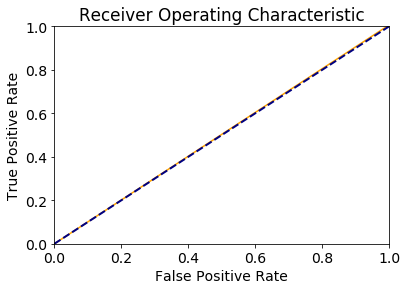

(array([1.00000000e+00, 9.99832860e-01, 9.99832860e-01, 9.99832860e-01,
        9.99832860e-01, 9.99832860e-01, 9.99665720e-01, 9.99582149e-01,
        9.99331439e-01, 9.99331439e-01, 9.99164299e-01, 9.99080729e-01,
        9.98830018e-01, 9.97910747e-01, 9.94567943e-01, 8.35701153e-05,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

In [155]:
roc2(calclass_lsvc.predict_proba(Xt_test_svc), y_test)

I screwed up by calibrating and training on the same data set, which is fatal to this technique. I'll have to go fix that.

In [ ]:
TPRs_calcla_lsvc, FPRs_gnb = sen_spec(probas=calclass_lsvc.predict_proba(Xt_test_svc), true=y_test, stat="specificity", stat_val = 0.99, step=0.01)


It would appear that having my classes unbalanced, cases of Arson make up only 16% of the instances in my sample. Has truly come back to haunt me. I will now deal with that in various ways.

In [ ]:
df_wburn.ARSON.value_counts()

In [ ]:
# Method 1: downsample majority class

df_minority = df_wburn[df_wburn['ARSON']==1]
df_majority = df_wburn[df_wburn['ARSON']==0]
 
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=59948,     # to match minority class
                                 random_state=42) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.ARSON.value_counts()

In [164]:
Xd = df_downsampled.drop(['ARSON'], axis=1)
yd = df_downsampled['ARSON']

In [170]:
X_train_down, X_test_down, y_train_down, y_test_down = train_test_split(Xd, yd, test_size=0.2, random_state=42)

In [171]:
pca_6_down = PCA(n_components=6)
pca_6_down.fit(X_train_down)
Xdt_train = pca_6_down.transform(X_train_down)
Xdt_test = pca_6_down.transform(X_test_down)

In [172]:
lr_down = LogisticRegression()
lr_down.fit(Xdt_train, y_train_down)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [174]:
lr_down.score(Xdt_test, y_test_down)

0.7121768140116764

In [175]:
rt_down = RandomTreesEmbedding(max_depth=4, n_estimators=n_estimator,
    random_state=42)

rt_lm_down = LogisticRegression()
pipeline_down = make_pipeline(rt_down, rt_lm_down)
pipeline_down.fit(Xdt_train, y_train_down)

Pipeline(memory=None,
     steps=[('randomtreesembedding', RandomTreesEmbedding(max_depth=4, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           random_state=42, sp...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [176]:
rf_down = RandomForestClassifier(max_depth=4, n_estimators=n_estimator)
rf_down.fit(Xdt_train, y_train_down)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [177]:
grd_down = GradientBoostingClassifier(n_estimators=n_estimator)
grd_down.fit(Xdt_train, y_train_down)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=10,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [178]:
xgb_down = XGBClassifier()
xgb_down.fit(Xdt_train, y_train_down)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [179]:
gnb_down = GaussianNB()
gnb.fit(Xdt_train, y_train_down)

GaussianNB(priors=None)

In [182]:
lsvc_down = LinearSVC(fit_intercept=False, random_state=42)
lsvc_down.fit(Xdt_train, y_train_down)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=False,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

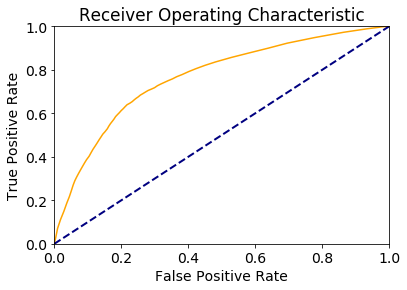

(array([1.        , 0.99991568, 0.99991568, 0.99974703, 0.9996627 ,
        0.99957838, 0.99957838, 0.99957838, 0.99957838, 0.99957838,
        0.99940973, 0.99940973, 0.99924108, 0.99924108, 0.99924108,
        0.99907243, 0.99890379, 0.99890379, 0.99890379, 0.99865081,
        0.99856649, 0.99839784, 0.99797622, 0.99536217, 0.98836327,
        0.97259465, 0.94805633, 0.92267476, 0.89956995, 0.87781432,
        0.8571549 , 0.83666414, 0.8208112 , 0.8054642 , 0.79188802,
        0.7785648 , 0.76827726, 0.75849566, 0.74997892, 0.74205245,
        0.7345476 , 0.7268741 , 0.71793575, 0.71110549, 0.70511848,
        0.69870984, 0.69061472, 0.68395312, 0.67577367, 0.66885909,
        0.6611856 , 0.65418669, 0.6465132 , 0.63959862, 0.63082891,
        0.62096298, 0.61295219, 0.60283329, 0.59406358, 0.58495657,
        0.5728139 , 0.56286365, 0.55240745, 0.54077072, 0.52938696,
        0.51581078, 0.50425837, 0.49186272, 0.47828653, 0.46352981,
        0.44978497, 0.43410068, 0.41816342, 0.40

In [183]:
roc2(lr_down.predict_proba(Xdt_test), y_test_down)

In [216]:
TPRs_lr_down, FPRs_lr_down = sen_spec(probas=lr_down.predict_proba(Xdt_test), true=y_test_down, stat="specificity", stat_val = 0.99, step=0.01)


Specificity: 99.02648%, Sensitivity: 7.09166%, Threshold: 87.0%


In [217]:
auc(TPRs_lr_down, FPRs_lr_down)

0.2340941317472297

Not exactly the sensitivity score I was looking for. AUC-ROC score is at 76.6%, not really a change.

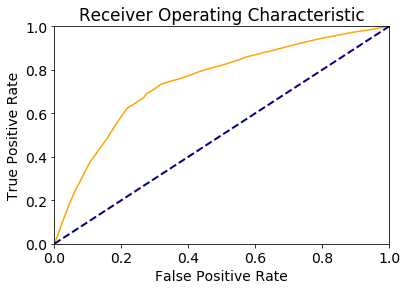

(array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 9.99747028e-01,
        9.99494055e-01, 9.99072434e-01, 9.98735138e-01, 9.98482165e-01,
        9.96205414e-01, 9.95783793e-01, 9.94434607e-01, 9.90049751e-01,
        9.86592461e-01, 9.83809765e-01, 9.81785985e-01, 9.71835737e-01,
        9.55814150e-01, 9.44177418e-01, 9.17193693e-01, 8.89029429e-01,
        8.59853276e-01, 8.54372207e-01, 8.45771144e-01, 8.23846867e-01,
        8.02175563e-01, 7.94502066e-01, 7.92478287e-01, 7.87418838e-01,
        7.75697782e-01, 7.70722658e-01, 7.69626444e-01, 7.65494561e-01,
        7.62543216e-01, 7.61952947e-01, 7.39775698e-01, 7.38679484e-01,
        7.36318408e-01, 7.32186525e-01, 7.31680580e-01, 7.31680580e-01,
        7.28391939e-01, 7.23416814e-01, 7.17598448e-01, 7.07226579e-01,
        6.94830930e-01, 6.89265537e-01, 6.86482840e-01, 6.824352

In [187]:
roc2(pipeline_down.predict_proba(Xdt_test), y_test_down)

In [214]:
TPRs_pipeline_down, FPRs_pipeline_down = sen_spec(probas=pipeline_down.predict_proba(Xdt_test), true=y_test_down, stat="sensitivity", stat_val = 0.99, step=0.01)


Sensitivity: 99.00498%, Specificity: 3.83632%, Threshold: 19.0%


In [215]:
auc(TPRs_pipeline_down, FPRs_pipeline_down)

0.25253922559632647

That actually got worse. Something is wrong.

In [197]:
print((Xdt_train).shape)
print((Xdt_test).shape)
print((y_train_down).value_counts())
print((y_test_down).value_counts())

(95916, 6)
(23980, 6)
1    48089
0    47827
Name: ARSON, dtype: int64
0    12121
1    11859
Name: ARSON, dtype: int64


The sizes and value counts are right. I'm not sure what's going on here. I can't find a mistake.

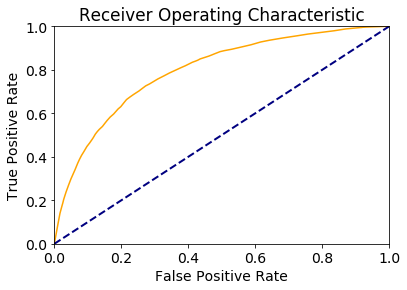

(array([1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        0.99957838, 0.99932541, 0.99679568, 0.99578379, 0.99494055,
        0.99443461, 0.9881103 , 0.97984653, 0.96441521, 0.95707901,
        0.94679147, 0.93633527, 0.92807151, 0.91533856, 0.90361751,
        0.89476347, 0.88835484, 0.88380133, 0.87418838, 0.8676111 ,
        0.86331057, 0.85707058, 0.85032465, 0.84442196, 0.83995278,
        0.83497765, 0.81904039, 0.81001771, 0.80352475, 0.78539506,
        0.77333671, 0.75807404, 0.74610001, 0.73539084, 0.72628384,
        0.71304494, 0.70326334, 0.68707311, 0.67476178, 0.66346235,
        0.65292183, 0.64288726, 0.63057593, 0.62011974, 0.5965933 ,
        0.58310144, 0.56741715, 0.55485285, 0.53967451, 0.52635129,
        0.51606375, 0.50442702, 0.48823678, 0.47972004, 0.46352981,
        0.44750822, 0.42406611, 0.40677966, 0.38

In [198]:
roc2(rf_down.predict_proba(Xdt_test), y_test_down)

In [212]:
TPRs_rf_down, FPRs_rf_down = sen_spec(probas=rf_down.predict_proba(Xdt_test), true=y_test_down, stat="sensitivity", stat_val = 0.99, step=0.01)


Sensitivity: 98.81103%, Specificity: 12.99398%, Threshold: 21.0%


In [213]:
auc(TPRs_rf_down, FPRs_rf_down)

0.2044200967673271

Interesting the downsampled data provided an rf with 1% higher sensitivity.

In [114]:
roc2(grd_down.predict_proba(Xt_test), y_test)

NameError: name 'grd_down' is not defined

In [211]:
TPRs_grd_down, FPRs_grd_down = sen_spec(probas=grd_down.predict_proba(Xdt_test), true=y_test_down, stat="sensitivity", stat_val = 0.99, step=0.01)


Sensitivity: 99.08930%, Specificity: 11.08819%, Threshold: 31.0%


In [204]:
auc(TPRs_grd_down, FPRs_grd_down)

0.20120755288021486

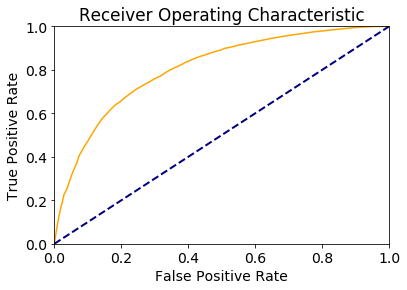

(array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.00000000e+00, 9.99915676e-01, 9.99409731e-01, 9.98988110e-01,
        9.98060545e-01, 9.97301627e-01, 9.96289738e-01, 9.95024876e-01,
        9.93422717e-01, 9.91651910e-01, 9.87772999e-01, 9.84400034e-01,
        9.80352475e-01, 9.74365461e-01, 9.67113585e-01, 9.59946033e-01,
        9.53115777e-01, 9.48393625e-01, 9.42912556e-01, 9.36841218e-01,
        9.26469348e-01, 9.18711527e-01, 9.13820727e-01, 9.07833713e-01,
        9.02268319e-01, 8.98136436e-01, 8.90800236e-01, 8.85403491e-01,
        8.81187284e-01, 8.74947297e-01, 8.67611097e-01, 8.61877055e-01,
        8.55552745e-01, 8.47794924e-01, 8.41301965e-01, 8.31857661e-01,
        8.23087950e-01, 8.17100936e-01, 8.09174467e-01, 8.00320432e-01,
        7.91803693e-01, 7.83624252e-01, 7.70975630e-01, 7.57736740e-01,
        7.45172443e-01, 7.34884898e-01, 7.19200607e-01, 7.07395227e-01,
        6.97444978e-01, 6.88590944e-01, 6.79736909e-01, 6.718947

In [205]:
roc2(xgb_down.predict_proba(Xdt_test), y_test_down)

In [113]:
TPRs_xgb_down, FPRs_xgb_down = sen_spec(probas=xgb_down.predict_proba(Xdt_test), true=y_test_down, stat="specificity", stat_val = 0.99, step=0.01)


NameError: name 'xgb_down' is not defined

In [210]:
auc(TPRs_xgb_down, FPRs_xgb_down)

0.19359428848188498

Method 2: upsampling the minority class: fires started by aronists.